In [337]:
# python=3.8
# conda env name : gender_pred_env

# Packges

In [338]:
import joblib
import numpy as np
import pandas as pd
import warnings
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, Flatten, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Adjusting warnings
warnings.filterwarnings('ignore')

In [339]:
# Load Data
df = pd.read_pickle('data/dataset_after_preporcessing.pkl')
df.head()

,name,sex,name_length,last_letter,last_two_letters,first_letter,first_two_letters
0,ابتسام,0,6,م,ام,ا,اب
1,ابتهاج,0,6,ج,اج,ا,اب
2,ابتهال,0,6,ل,ال,ا,اب
3,اجتهاد,0,6,د,اد,ا,اج
4,ازدهار,0,6,ر,ار,ا,از


In [340]:
max_name_length = max(df['name'].apply(len))
unique_chars = set(''.join(df['name']))  
vocab_size = len(unique_chars) + 1  

# Tokenizing and padding the 'name' column for LSTM input
tokenizer = Tokenizer(num_words=vocab_size, char_level=True)  # char_level=True for character tokenization
tokenizer.fit_on_texts(df['name'])
sequences = tokenizer.texts_to_sequences(df['name'])
padded_sequences = pad_sequences(sequences, maxlen=max_name_length)

In [341]:
first_letter = df['name'].apply(lambda x: x[0])
last_letter = df['name'].apply(lambda x: x[-1])

first_letter_encoded = np.array([ord(char) for char in first_letter])
last_letter_encoded = np.array([ord(char) for char in last_letter])

max_unicode_value_first = np.max(first_letter_encoded)
max_unicode_value_last = np.max(last_letter_encoded)
max_unicode_value = max(max_unicode_value_first, max_unicode_value_last)

In [342]:
scaler = MinMaxScaler()

first_letter_encoded_scaled = scaler.fit_transform(first_letter_encoded.reshape(-1, 1))
last_letter_encoded_scaled = scaler.fit_transform(last_letter_encoded.reshape(-1, 1))


scaler_first = scaler.fit(first_letter_encoded.reshape(-1, 1))
scaler_last = scaler.fit(last_letter_encoded.reshape(-1, 1))

# Save the scaler models to disk
joblib.dump(scaler_first, 'data/scaler_first.pkl')
joblib.dump(scaler_last, 'data/scaler_last.pkl');

In [343]:
names_lengths = df['name_length'].values

In [344]:
X = list(zip(padded_sequences, first_letter_encoded_scaled, last_letter_encoded_scaled))

# Define the size for the test and validation sets as percentages
test_size_percentage = 0.1
validation_size_percentage = 0.1

# Calculate the actual sizes for the test and validation sets
total_size = test_size_percentage + validation_size_percentage
test_size_actual = test_size_percentage / total_size
validation_size_actual = validation_size_percentage / total_size

# First split: Separate out the training data and the remaining data
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=total_size, random_state=11)

# Second split: Separate the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=test_size_actual, random_state=11)

# Print the number of samples in the training, validation, and test sets
print(f"Training set size: {len(X_train)}, Labels: {len(y_train)}")
print(f"Validation set size: {len(X_val)}, Labels: {len(y_val)}")
print(f"Test set size: {len(X_test)}, Labels: {len(y_test)}")

# Unpack the training data into separate arrays for each input
name_train, first_letter_train, last_letter_train = zip(*X_train)
name_val, first_letter_val, last_letter_val = zip(*X_val)
name_test, first_letter_test, last_letter_test = zip(*X_test)

# Convert tuples to numpy arrays
name_train = np.array(name_train)
first_letter_train = np.array(first_letter_train)
last_letter_train = np.array(last_letter_train)

name_val = np.array(name_val)
first_letter_val = np.array(first_letter_val)
last_letter_val = np.array(last_letter_val)

name_test = np.array(name_test)
first_letter_test = np.array(first_letter_test)
last_letter_test = np.array(last_letter_test)

# Concatenate the features
X_combined_train = np.concatenate([name_train, first_letter_train, last_letter_train], axis=1)
X_combined_val = np.concatenate([name_val, first_letter_val, last_letter_val], axis=1)
X_combined_test = np.concatenate([name_test, first_letter_test, last_letter_test], axis=1)

Training set size: 6922, Labels: 6922
Validation set size: 865, Labels: 865
Test set size: 866, Labels: 866


In [345]:
# max name length is 17

# Model parameters
embedding_dim = 1024
letter_embedding_dim = embedding_dim // 2

lstm_units = 256

total_features_shape = X_combined_train.shape[1]  # Total number of features after concatenation


l2_lambda = 0.001
dropout_rate = 0.2

batch_size = 256
epochs = 100

In [346]:

model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=total_features_shape))
model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
model.add(Dropout(dropout_rate))
model.add(Bidirectional(LSTM(lstm_units//2, kernel_regularizer=l2(l2_lambda), return_sequences=True)))
model.add(Dropout(dropout_rate))
model.add(Bidirectional(LSTM(lstm_units//2, kernel_regularizer=l2(l2_lambda), return_sequences=True)))
model.add(LSTM(lstm_units//4, kernel_regularizer=l2(l2_lambda)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, 19, 1024)          37888     
                                                                 
 bidirectional_57 (Bidirecti  (None, 19, 512)          2623488   
 onal)                                                           
                                                                 
 dropout_50 (Dropout)        (None, 19, 512)           0         
                                                                 
 bidirectional_58 (Bidirecti  (None, 19, 256)          656384    
 onal)                                                           
                                                                 
 dropout_51 (Dropout)        (None, 19, 256)           0         
                                                                 
 bidirectional_59 (Bidirecti  (None, 19, 256)        

In [347]:
model_architecture_str = []

# Define a function to append each line of the model summary to the list
def append_model_summary(line):
    model_architecture_str.append(line)

# Generate model summary
model.summary(print_fn=append_model_summary)

# Convert list to string
model_architecture_str = '\n'.join(model_architecture_str)

In [348]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# # Define the BiLSTM model adjusted for character-level input
# model = Sequential()

# model.add(Embedding(input_dim=vocab_size ,output_dim=embedding_dim, input_length=total_features_shape))

# model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))

# model.add(Dropout(dropout_rate))

# model.add(Bidirectional(LSTM(lstm_units//2, kernel_regularizer=l2(l2_lambda) ,return_sequences=True)))

# model.add(Dropout(dropout_rate))

# model.add(LSTM(lstm_units//4, kernel_regularizer=l2(l2_lambda)))

# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()

In [349]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Gender Prediction Models Tracking")

<Experiment: artifact_location='mlflow-artifacts:/237850698007442871', creation_time=1704716553191, experiment_id='237850698007442871', last_update_time=1704716553191, lifecycle_stage='active', name='Gender Prediction Models Tracking', tags={}>

In [350]:
# MLflow tracking
with mlflow.start_run():
    # Log model parameters
    mlflow.log_params({
        "embedding_dim": embedding_dim,
        "lstm_units": lstm_units,
        "max_name_length": max_name_length,
        "vocab_size": vocab_size,
        "epochs": epochs,
        "batch_size": batch_size,
        "l2_reg": l2_lambda,
        "dropout_rate": dropout_rate,
        "train_size_percentage": train_size_percentage,
        "test_size_percentage": test_size_percentage,
        "validation_size_percentage": validation_size_percentage,
    })

    # Train the model
    history = model.fit(
        X_combined_train,
        y_train,
        validation_data=(X_combined_val, y_val),
        callbacks=[early_stopping],
        epochs=epochs
    )
    # Log training history
    for epoch in range(len(history.history['accuracy'])):
        mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_combined_test, y_test)

    # Predictions and additional metrics
    y_pred = model.predict(X_combined_test)
    y_pred_classes = np.where(y_pred > 0.5, 1, 0).reshape(-1)
    f1 = f1_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Confusion matrix calculation
    cm = confusion_matrix(y_test, y_pred_classes)
    cm_dict = {f"{i}-{j}": cm[i, j] for i in range(cm.shape[0]) for j in range(cm.shape[1])}

    # Log additional metrics
    mlflow.log_metrics({
    "val_f1_score": f1,
    "val_precision": precision,
    "val_recall": recall,
    "val_roc_auc": roc_auc,
    "val_loss": loss, 
    "val_accuracy": accuracy
    })

    # Infer the signature using the combined data and predictions
    signature = infer_signature(X_combined_test, y_pred)

    mlflow.keras.log_model(model, "model", signature=signature)

    # Set additional tags
    mlflow.set_tags({
        "Description": "Character-Level BiLSTM",
        "Encoding": "Character-Level for name | other featuers Coverting them to thier ASCI value then norm",
        "Features": ', '.join(df.columns.tolist()),
        'Number of Features':len(df.columns.tolist()),
        "Model Type": "BiLSTM",
        "model_architecture": model_architecture_str,
        'confusion_matrix':list(cm_dict.values())
    })

print()
print('-----------------------------------------------------------')
print(f"Validation Accuracy: {round(accuracy, 3)}")
print(f"F1 Score: {round(f1, 3)}")
print(f"Precision: {round(precision, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"ROC AUC: {round(roc_auc, 3)}")
print('-----------------------------------------------------------')
# End MLflow run

Epoch 1/100


217/217 [==============================] - ETA: 0s - loss: 0.7825 - accuracy: 0.7845

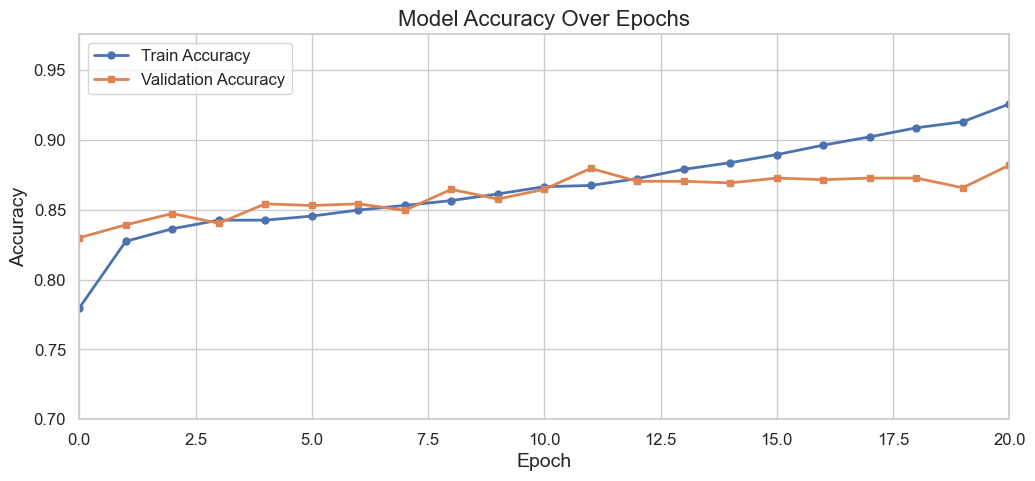

In [ ]:
# Apply the seaborn style to make plots nicer
sns.set(style="whitegrid")

# Create the figure with a specific size
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o', markersize=5)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=5)

# Title and labels
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

# Legend
plt.legend(loc='upper left', fontsize=12)

# Set limits and ticks for readability
plt.xlim(0, len(history.history['accuracy']) - 1)
plt.ylim(0.7, max(max(history.history['accuracy']), max(history.history['val_accuracy'])) + 0.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

Text(92.25, 0.5, 'True Label')

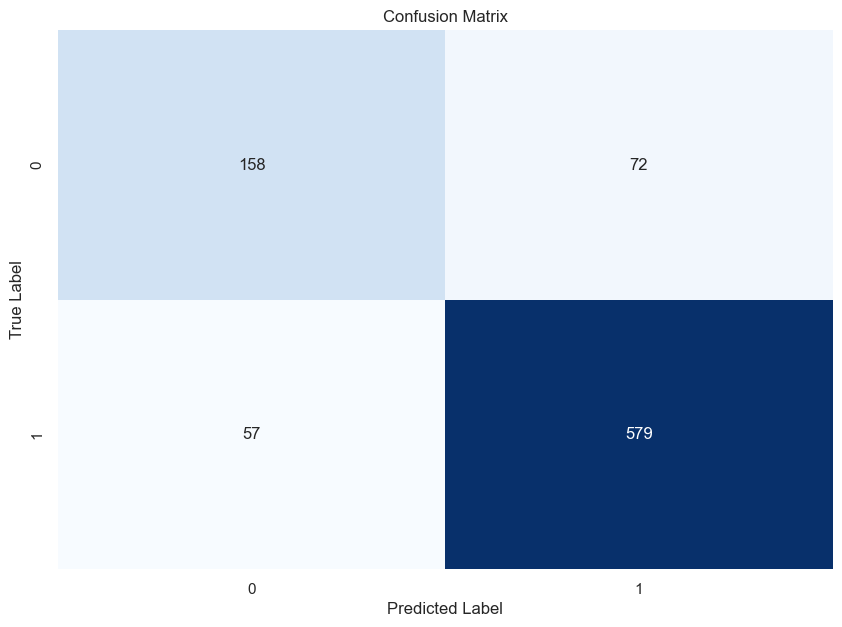

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [ ]:
# model.save("BiLSTM-87_val_acc-91_f_sc.h5")